In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeled_train_clean_reviews.csv'
TEST_DF = BASE_DIR + 'test_clean_reviews.csv'

In [2]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0)
test = pd.read_csv(TEST_DF, header = 0)
labeled_train["review"] = labeled_train["review"].astype(str)
test["review"] = test["review"].astype(str)
print "Read %d labeled train reviews" \
          "and %d test reviews" % (labeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviewsand 25000 test reviews


Data leakage

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [4]:
import fastText
EMBEDDING_DIM = 300  # Word vector dimensionality
fasttext_model = fastText.load_model("../input/fasttext_300features_40minwords_10context_pretrained_cc.bin")

Prepare

In [5]:
train_clean_reviews = labeled_train["review"].tolist()
test_clean_reviews = test["review"].tolist()

all_clean_reviews = train_clean_reviews + test_clean_reviews

In [6]:
print(np.random.choice(all_clean_reviews, 1))

['everything was better in past days  even children s television  and fraggle rock proves my point quite easily  at the time of writing this comment i am fourteen years old but even in my teen years i can t resist the charm of fraggle rock  for those of you that have indeed been living under a rock  haha    fraggle rock is about a horde of playful and goofy creatures called fraggles who live amazingly in a rock  but they re not the only creatures  the rock is inhabited with many other species like the hardworking doozers and countless living plants  outside the rock on one side live inventor scientist doc and his dog sprocket  who later befriends gobo fraggle   on the other side a family of gorgs supposed rulers of the universe  the five main fraggles gobo  fearless leader   mokey  arty and peaceful   wembley  indecisive and a friend to gobo   boober  a pessimistic domestic god  and red  loves anything to do with sport and general feistyness get caught up in some strange situations eac

In [7]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Using TensorFlow backend.


Keras Tokenizer found 101376 unique tokens


In [8]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [9]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_matrix[i] = fasttext_model.get_word_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
# Null word embeddings is one because index 0 does not match any tokens. keras tokenizer uses 1-based index.

Null word embeddings: 1


In [10]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [11]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, Conv1D, MaxPooling1D ,GlobalMaxPooling1D
from keras.initializers import Constant

In [13]:
def cnn_rnn_model(dropout_cnn=0.5, dropout_rnn=0.2, num_filters=64, kernel_size=2):
    model = Sequential()
    
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.

    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=1))
    # Cannot use GlobalMaxPooling since you're feeding it into RNN
    model.add(MaxPooling1D(2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_cnn))
    model.add(Bidirectional(LSTM(LSTM_UNITS, 
                                 dropout=LSTM_DROPOUT, 
                                 recurrent_dropout=LSTM_RECCURENT_DROPOUT
                                )))
    model.add(Dropout(dropout_rnn))
    model.add(output_layer)
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [14]:
model = cnn_rnn_model()

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30413100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 64)           38464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 249, 32)           2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 249, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [16]:
# batch_size: number of samples per gradient update
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 295s 15ms/step - loss: 0.5847 - acc: 0.6905 - val_loss: 0.4240 - val_acc: 0.8236
Epoch 2/10
20000/20000 [==============================] - 291s 15ms/step - loss: 0.4008 - acc: 0.8317 - val_loss: 0.3486 - val_acc: 0.8536
Epoch 3/10
20000/20000 [==============================] - 291s 15ms/step - loss: 0.3354 - acc: 0.8624 - val_loss: 0.3570 - val_acc: 0.8464
Epoch 4/10
20000/20000 [==============================] - 292s 15ms/step - loss: 0.3047 - acc: 0.8762 - val_loss: 0.2981 - val_acc: 0.8798
Epoch 5/10
20000/20000 [==============================] - 290s 14ms/step - loss: 0.2870 - acc: 0.8853 - val_loss: 0.2795 - val_acc: 0.8844
Epoch 6/10
20000/20000 [==============================] - 291s 15ms/step - loss: 0.2886 - acc: 0.8816 - val_loss: 0.3373 - val_acc: 0.8564
Epoch 7/10
20000/20000 [==============================] - 292s 15ms/step - loss: 0.2808 - acc: 0.8877 - val_loss: 0.3

In [17]:
y_test_pred = model.predict(x_test)

In [18]:
y_test_pred_binary = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred)

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [20]:
print("The AUC score for CNN-BiLSTM model is : %.5f." %roc_auc_score(y_test, y_test_pred_binary))

The AUC score for CNN-BiLSTM model is : 0.90176.


In [21]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary})
output.to_csv(os.path.join('../', 'output', "cnn_bilstm_fasttext_supervised_cc.csv"), index=False, quoting=3)
print "Wrote to cnn_bilstm_fasttext_supervised_cc.csv"

Wrote to cnn_bilstm_fasttext_supervised_cc.csv


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

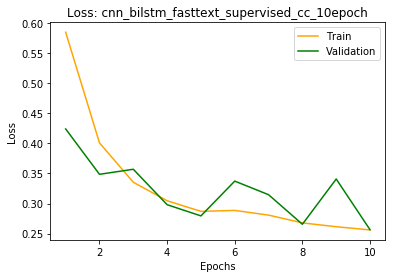

In [2]:
loss = [0.5847, 0.4008, 0.3354, 0.3047, 0.2870, 0.2886, 0.2808, 0.2679, 0.2615, 0.2562]
val_loss = [0.4240, 0.3486, 0.3570, 0.2981, 0.2795, 0.3373, 0.3147, 0.2656, 0.3408, 0.2565]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: cnn_bilstm_fasttext_supervised_cc_10epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/cnn_bilstm_fasttext_supervised_cc_10epoch_loss.png', dpi=900)

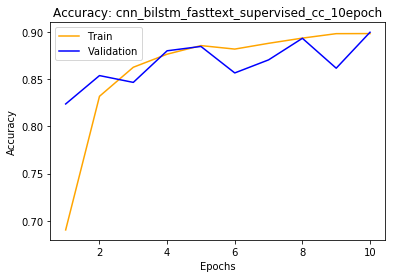

In [3]:
acc = [0.6905, 0.8317, 0.8624, 0.8762, 0.8853, 0.8816, 0.8877, 0.8932, 0.8979, 0.8980]
val_acc = [0.8236, 0.8536, 0.8464, 0.8798, 0.8844, 0.8564, 0.8702, 0.8930, 0.8614, 0.8994]

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: cnn_bilstm_fasttext_supervised_cc_10epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/cnn_bilstm_fasttext_supervised_cc_10epoch_accuracy.png', dpi=900)